In [1]:
import os
import numpy as np
import random
from datetime import datetime
import time
import math
import gdown
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import *
from tensorflow.keras.layers import Conv2D, ReLU, MaxPooling2D, Dense, BatchNormalization, GlobalAveragePooling2D, Softmax

AUTOTUNE = tf.data.AUTOTUNE

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train.shape

(50000, 32, 32, 3)

In [5]:
## Hyper-Parameter 설정
# image resolution
# 최적화 된 값은 아님
RES = 32
# class 수 
N_CLASS = 10
# batch size
N_BATCH = 64
# epoch 수
N_EPOCH = 60
# learning rate
LR = 0.0001

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(1000).batch(N_BATCH)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.batch(N_BATCH)

In [21]:
# MoileNet

In [22]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [23]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 32, 32, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 16, 16, 16)   432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 16, 16, 16)   64          Conv[0][0]                       
___________________________________________________________________________________

In [24]:
def create_model():
    inputs = tf.keras.Input(shape=(RES, RES, 3))

    x = preprocess_input(inputs) 
    x = mobilenetv3(x) # outputd이 7 by 7 이 나옴
    x = GlobalAveragePooling2D()(x) # outputd이 1 by 1 이 나옴
    x = Dense(N_CLASS)(x)
    x = BatchNormalization()(x)
    outputs = Softmax()(x)
    model = keras.Model(inputs=inputs, outputs=outputs) 

    return model

In [25]:
model = create_model()

In [26]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                10250     
_________________________________________________________________
batch_normalization_1 (Batch (None, 10)                40        
_________________________________________________________________
softmax_1 (Softmax)          (None, 10)                0         
Total params: 1,540,258
Trainable params: 1,528,126
Non-trainable params: 12,132
____________________________________________

In [27]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

In [28]:
train_loss = tf.keras.metrics.Mean()
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

test_loss = tf.keras.metrics.Mean()
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

In [29]:
@tf.function 
def train_step(image, label): 
    with tf.GradientTape() as tape: 
        predictions = model(image)
        loss = loss_object(label, predictions) 
        
    gradient = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradient, model.trainable_variables))
    
    train_loss(loss) 
    train_accuracy(label, predictions)

In [30]:
@tf.function 
def test_step(image, label): 
    with tf.GradientTape() as tape: 
        predictions = model(image)
        loss = loss_object(label, predictions) 
        
    # gradient = tape.gradient(loss, model.trainable_variables)
    # optimizer.apply_gradient(zip(gradient, model.trainable_variables))
    
    test_loss(loss) 
    test_accuracy(label, predictions)

In [31]:
for epoch in range(N_EPOCH):
    
    for image, label in train_ds: 
        train_step(image, label)
        
    for image, label in test_ds: 
        test_step(image, label)
        
    temp = 'epoch : {}, loss : {}, accuracy : {}, test_loss : {}, test_accuracy : {}'
    print(temp.format(epoch+1
                    , train_loss.result() 
                    , train_accuracy.result() * 100 
                    , test_loss.result() 
                    , test_accuracy.result() * 100))
        

epoch : 1, loss : 1.3933461904525757, accuracy : 49.00600051879883, test_loss : 1.0820732116699219, test_accuracy : 61.209999084472656
epoch : 2, loss : 1.192715048789978, accuracy : 56.85300064086914, test_loss : 1.0623244047164917, test_accuracy : 62.755001068115234
epoch : 3, loss : 1.0897800922393799, accuracy : 60.88866424560547, test_loss : 1.003133773803711, test_accuracy : 64.80332946777344
epoch : 4, loss : 1.0175180435180664, accuracy : 63.612998962402344, test_loss : 0.9862399697303772, test_accuracy : 65.5625
epoch : 5, loss : 0.9616182446479797, accuracy : 65.68280029296875, test_loss : 0.980701744556427, test_accuracy : 65.95999908447266
epoch : 6, loss : 0.9162700772285461, accuracy : 67.357666015625, test_loss : 0.9821296334266663, test_accuracy : 66.18999481201172
epoch : 7, loss : 0.876941978931427, accuracy : 68.78913879394531, test_loss : 0.9745728373527527, test_accuracy : 66.7171401977539
epoch : 8, loss : 0.8427027463912964, accuracy : 70.02074432373047, test_los

In [42]:
model.save('mobilenet_without_data_aug')

INFO:tensorflow:Assets written to: mobilenet_without_data_aug\assets


C:\Users\Sehwan Yoo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [3]:
model = tf.keras.models.load_model('mobilenet_without_data_aug')

tf.Tensor([2], shape=(1,), dtype=uint8)


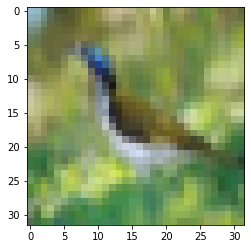

In [11]:
# train_ds.take(1) 
for image, label in train_ds.take(1):
    pass 

plt.imshow(image[0].numpy().astype('uint8'))
print(label[0])
  

In [50]:
test = model.predict(train_ds.take(1))
np.argmax(test)

67

In [37]:
from tensorflow.keras.utils import plot_model

plot_model(model)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [22]:
# train_ds.map()
def aug(image, label):
  image = tf.image.random_crop(image, [RES, RES, 3])
  image = tf.image.random_flip_left_right(image) 
  return image, label

In [23]:
# unbatch 를 하지 않을 경우 batch 단위로 똑같이 crop 등이 되어버린다 
# 그렇기 때문에 unbatch 를 통해 한장씩 한장식 랜덤으로 처리를 해야함

# num_parallel_calls : 병렬 처리
# .batch unbatch 한것을 다시 batch를 해줌
# drop_remainder True 로 했을 경우, 데이터셋이 배치 사이즈대로 안맞아도 나머지를 처리한다 (배치사이즈에 맞게, 짜투리=> 버림)
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).prefetch(AUTOTUNE)

In [24]:
model = create_model()

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(LR)
            , loss=tf.keras.losses.SparseCategoricalCrossentropy()
            , metrics=['accuracy']
)

In [29]:
model.fit(train_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
219/219 [==============================] - 61s 247ms/step - loss: 0.5479 - accuracy: 0.9010 - val_loss: 0.4707 - val_accuracy: 0.9190
Epoch 2/5
219/219 [==============================] - 53s 240ms/step - loss: 0.4306 - accuracy: 0.9419 - val_loss: 0.4985 - val_accuracy: 0.9210
Epoch 3/5
219/219 [==============================] - 53s 241ms/step - loss: 0.4006 - accuracy: 0.9471 - val_loss: 0.4795 - val_accuracy: 0.9270
Epoch 4/5
219/219 [==============================] - 53s 240ms/step - loss: 0.3790 - accuracy: 0.9531 - val_loss: 0.4760 - val_accuracy: 0.9283
Epoch 5/5
219/219 [==============================] - 53s 240ms/step - loss: 0.3526 - accuracy: 0.9615 - val_loss: 0.4723 - val_accuracy: 0.9227


### cutmix 알고리즘

In [43]:
def cutmix(images, labels):
  imgs = []; labs = []

  for i in range(N_BATCH):
    APPLY = tf.cast(tf.random.uniform(()) >= 0.5, tf.int32) 
    idx = tf.random.uniform((), 0, N_BATCH, tf.int32)

    w = RES 
    h = RES 

    lam = tf.random.uniform(())
    cut_ratio = tf.math.sqrt(1.-lam) 
    cut_w = tf.cast(w * cut_ratio, tf.int32) * APPLY
    cut_h = tf.cast(h * cut_ratio, tf.int32) * APPLY

    cx = tf.random.uniform((), int(w/8), int(7/8*w), tf.int32)
    cy = tf.random.uniform((), int(h/8), int(7/8*h), tf.int32)

    xmin = tf.clip_by_value(cx - cut_w//2, 0, w)
    ymin = tf.clip_by_value(cy - cut_h//2, 0, h)
    xmax = tf.clip_by_value(cx + cut_w//2, 0, w)
    ymax = tf.clip_by_value(cy + cut_h//2, 0, h)

    # xmax = tf.clip_by_value(cx + cut_w//2, 0, w)
    # xmax = tf.clip_by_value(cx + cut_h//2, 0, h)
    # ymax = tf.clip_by_value(cy + cut_w//2, 0, w)
    # ymax = tf.clip_by_value(cy + cut_h//2, 0, h)

    mid_left = images[i, ymin:ymax, :xmin, :]
    mid_mid = images[idx, ymin:ymax, xmin:xmax, :]
    mid_right = images[i, ymin:ymax, xmax:, :]
    middle = tf.concat([mid_left, mid_mid, mid_right], axis=1) 
    top = images[i, :ymin, :, :]
    bottom = images[i, ymax:, :, :]

    new_imgs = tf.concat([top, middle, bottom], axis=0)
    imgs.append(new_imgs)

    cut_w_mod = xmax - xmin
    cut_h_mod = ymax - ymin

    alpha = tf.cast((cut_w_mod * cut_h_mod) / (w*h), tf.float32)

    label1 = labels[i] 
    label2 = labels[idx]

    new_label = ((1-alpha) * label1 + alpha * label2) 
    labs.append(new_label)

  new_imgs = tf.reshape(tf.stack(imgs), [-1, RES, RES, 3])
  new_labs = tf.reshape(tf.stack(labs), [-1, N_CLASS])


  return new_imgs, new_labs





In [44]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=AUTOTUNE).batch(N_BATCH, drop_remainder=True).map(cutmix, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

[0. 0. 0. 0. 0. 1.]


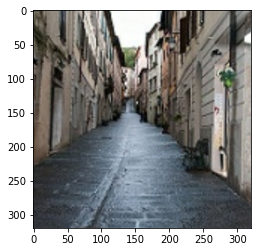

[0. 0. 0. 0. 0. 1.]


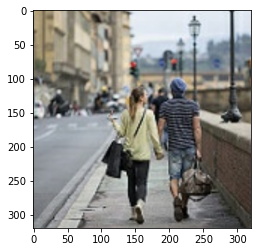

[0.5655762  0.         0.         0.43442383 0.         0.        ]


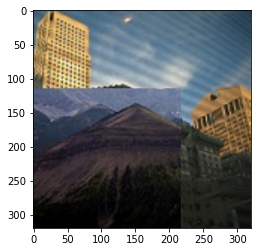

[0.7918359  0.         0.20816407 0.         0.         0.        ]


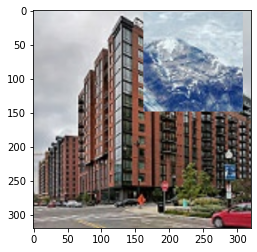

[0. 0. 0. 0. 0. 1.]


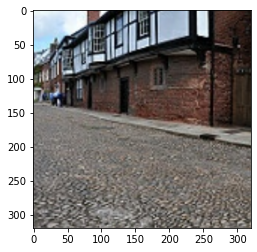

In [45]:
for images, labels in train_ds.take(5):
    # plt.imshow(images[0])
    plt.imshow(images[0].numpy().astype('uint8'))
    # plt.title(classes[labels[0].numpy()])
    print(labels[0].numpy())
    plt.show() 
